# sample genes- scvelo

In [1]:
# modified form https://github.com/GuangyuWangLab2021/veloNN/blob/main/tests/scanpy_th9_velocyto.py
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import anndata
srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'

sys.path.append(srcdir)
from celldancer.sampling import sampling_neighbors
from celldancer.cdplt import colormap
import celldancer.cdplt as cdplt
import os
import math

In [2]:
def pipline_run_sim_data(load_raw_data):

    # unsplice&splice
    splice_mat=load_raw_data.pivot(index='gene_name', values='splice', columns='cellID')
    unsplice_mat=load_raw_data.pivot(index='gene_name', values='unsplice', columns='cellID')

    one_gene_raw=load_raw_data[load_raw_data.gene_name==list(load_raw_data.gene_name)[0]]

    cols=one_gene_raw['cellID']
    splice_mat = splice_mat[cols].T
    unsplice_mat = unsplice_mat[cols].T
    splice_mat.to_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/build_scv_compatible_raw/splice.csv')
    unsplice_mat.to_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/build_scv_compatible_raw/unsplice.csv')

    splice_mat=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/build_scv_compatible_raw/splice.csv')
    unsplice_mat=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/build_scv_compatible_raw/unsplice.csv')

    adata_building=sc.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/build_scv_compatible_raw/splice.csv', delimiter=',', first_column_names=True, dtype='float32')
    adata_building.layers['Ms']=splice_mat.to_numpy()[:,1:]
    adata_building.layers['Mu']=unsplice_mat.to_numpy()[:,1:]

    adata_building.layers['Ms']=np.array(adata_building.layers['Ms'], dtype=float)
    adata_building.layers['Mu']=np.array(adata_building.layers['Mu'], dtype=float)

    adata_building_test=adata_building.copy()
    # adata_building_test2=adata_building.copy()

    # velocity
    # scv.pp.moments(adata_building_test, n_pcs=30, n_neighbors=30)
    # scv.pp.moments(adata_building_test, n_pcs=50, n_neighbors=50)

    # steady_state_velocity
    scv.tl.velocity(adata_building_test, vkey='steady_state_velocity', mode='steady_state')
    scv.tl.velocity_graph(adata_building_test, vkey='steady_state_velocity')

    # dynamical_velocity
    scv.tl.recover_dynamics(adata_building_test, n_jobs=30, n_top_genes = 1000)
    scv.tl.velocity(adata_building_test, vkey='dynamical_velocity',mode='dynamical',filter_genes=False)
    
    # plot - steady_state_velocity
    gene_choice=load_raw_data['gene_name'].drop_duplicates()

    for gene in list(gene_choice)[0:3]:
        scv.pl.velocity_embedding(adata_building_test, vkey='steady_state_velocity', basis=gene,
                            scale=.6, width=.0035, frameon=False, title=gene,show=False)
        # plot- dynamical_velocity
        scv.pl.velocity_embedding(adata_building_test, vkey='dynamical_velocity', basis=gene, scale=4, width=.0035,
                            frameon=False, title=gene,show=False)
        
    adata_building_test.write(filename='/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/build_scv_compatible_raw/neuro.h5ad')

    # gene velocity plot
    gene_choice=load_raw_data['gene_name'].drop_duplicates()
    # gene_choice=['simulation0','simulation1']

    outpath='/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/velocity_result'
    gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df=pd.DataFrame()
    for nth,gene in enumerate(gene_choice):
        if nth % 100 ==0: print(nth)
        # dynamical_velocity
        outpath='/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/velocity_result'
        save_path=os.path.join(outpath,'scvelo_result',('multi_path_'),(gene+'_dynamic.pdf'))
        X, V=scv.pl.velocity_embedding(adata_building_test, vkey='dynamical_velocity', basis=gene,
                            fontsize=16, frameon=False,show=False)
        splice_unsplice_splice_predict_unsplice_predict=np.concatenate((X, V), axis=1)

        # steady_state_velocity
        save_path=os.path.join(outpath,'scvelo_result',('multi_path_'),(gene+'_static.pdf'))
        X_steady, V_steady=scv.pl.velocity_embedding(adata_building_test, vkey='steady_state_velocity', basis=gene,
                          scale=.6, width=.0035, frameon=False,show=False)
        splice_unsplice_splice_predict_unsplice_predict_steady=np.concatenate((X_steady, V_steady), axis=1)

        one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady=np.hstack((splice_unsplice_splice_predict_unsplice_predict,splice_unsplice_splice_predict_unsplice_predict_steady))
        one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df = pd.DataFrame(one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady, columns = ['dynamic_splice','dynamic_unsplice','dynamic_splice_predict','dynamic_unsplice_predict','static_splice','static_unsplice','static_splice_predict','static_unsplice_predict'])
        one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df.insert (0, "gene_name", gene)
        gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df = pd.concat([gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df,one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df])
        
    gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df.to_csv(os.path.join(outpath,'scvelo_result_multi_path__splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df_neuro.csv'),index=False)

In [3]:
load_raw_data=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/raw_data/DentateGyrus.csv')


gene_list=['Klf7','Syt11','Gnao1','Dcx','Dctn3',
           'Gpm6b','Ptpro','Psd3','Ntrk2','Ncald',
           'Slc1a3','Astn1','Evl','Tbc1d16','Cadm1']

load_raw_data=load_raw_data[load_raw_data.gene_name.isin(gene_list)]

computing velocities
    finished (0:00:00) --> added 
    'steady_state_velocity', velocity vectors for each individual cell (adata.layers)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/48 cores)


  0%|          | 0/18140 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'steady_state_velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 30/48 cores)


  0%|          | 0/15 [00:00<?, ?gene/s]

    finished (0:00:06) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'dynamical_velocity', velocity vectors for each individual cell (adata.layers)
0


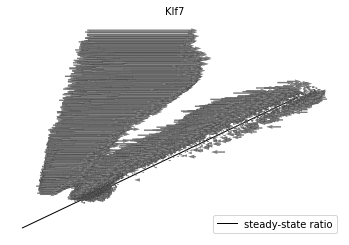

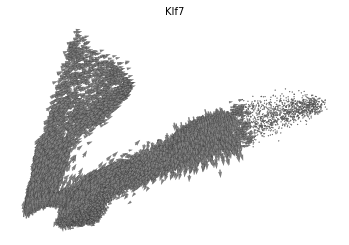

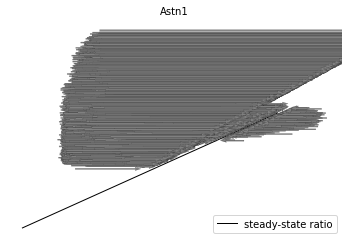

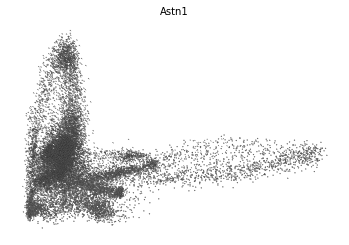

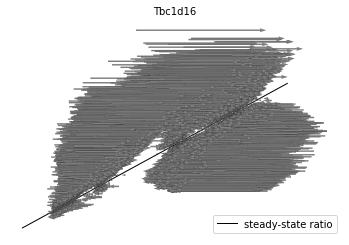

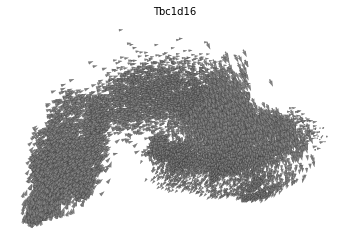

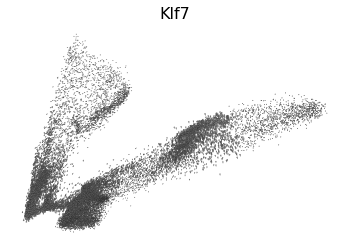

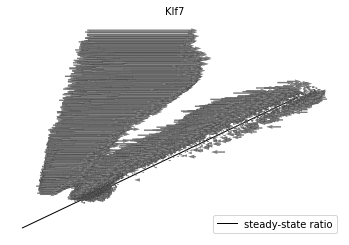

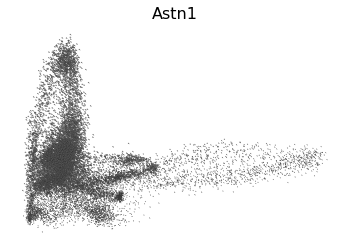

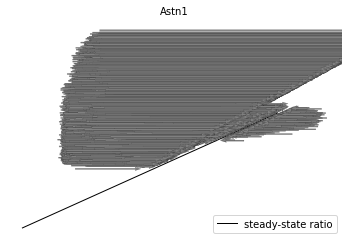

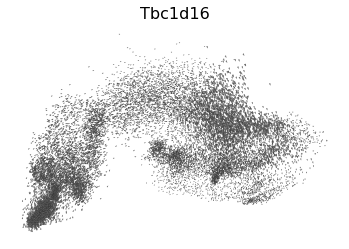

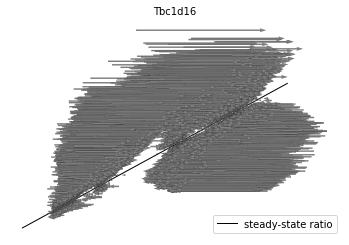

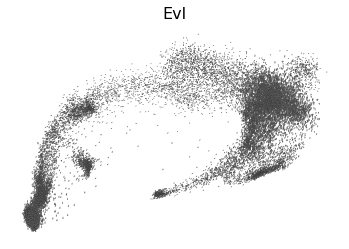

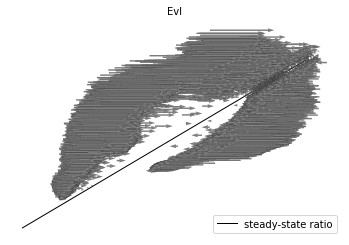

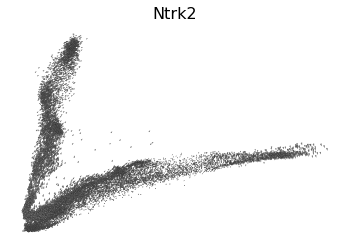

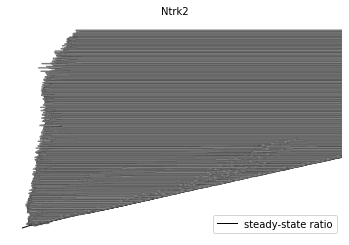

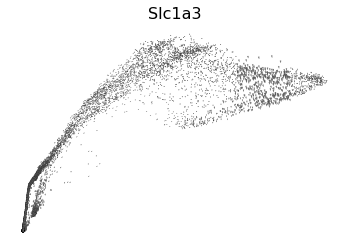

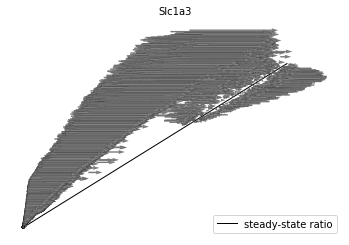

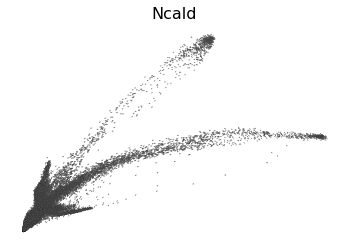

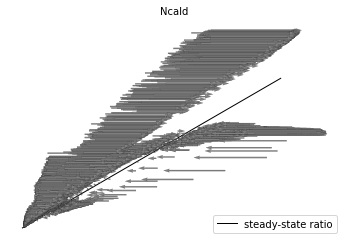

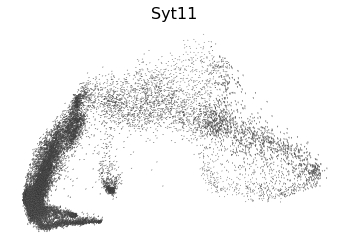

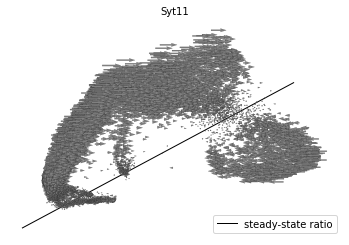

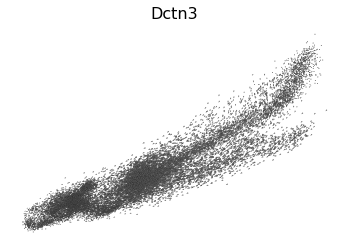

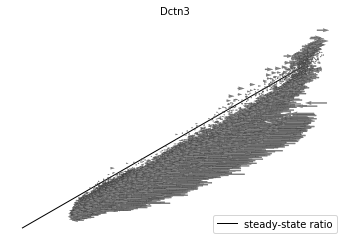

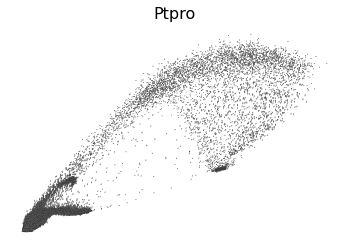

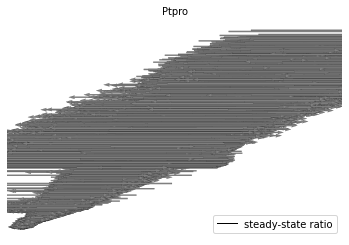

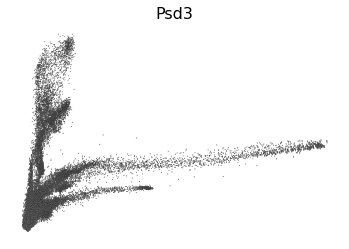

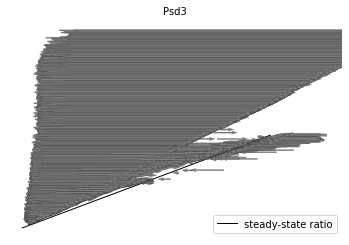

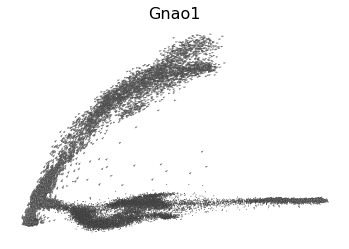

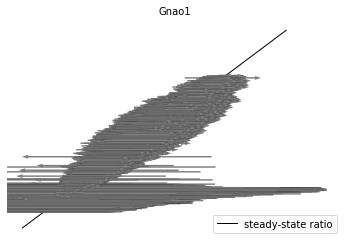

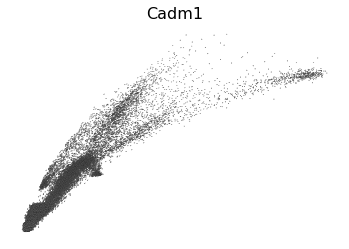

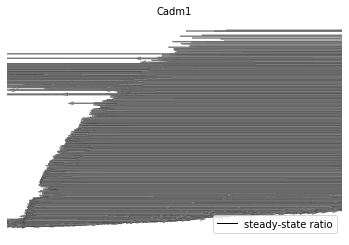

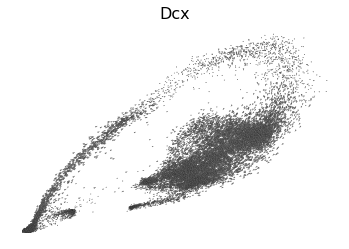

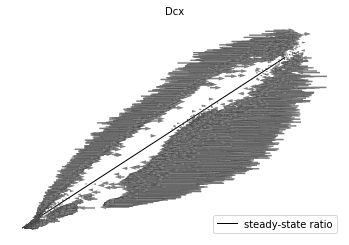

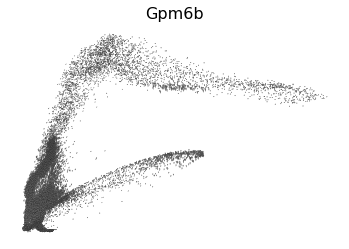

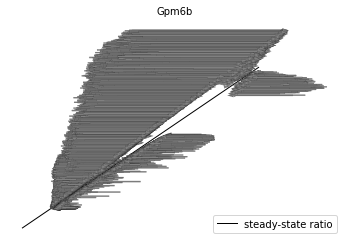

In [5]:
pipline_run_sim_data(load_raw_data)


In [30]:
onegene=load_raw_data[load_raw_data.gene_name==list(load_raw_data.gene_name)[0]]

onegene.loc[:,'cellID']=list(range(len(onegene)))

embed_info=onegene[['cellID','clusters','embedding1','embedding2']]

df_embed_info=pd.concat([embed_info]*len(gene_list), ignore_index=True)

df_embed_info=df_embed_info.reset_index(drop=True)

splice_unsplice_splice_predict_unsplice_predict_dynamic=pd.concat([df_embed_info,splice_unsplice_splice_predict_unsplice_predict_dynamic],axis=1)

In [33]:
splice_unsplice_splice_predict_unsplice_predict_static=pd.concat([df_embed_info,splice_unsplice_splice_predict_unsplice_predict_static],axis=1)

static


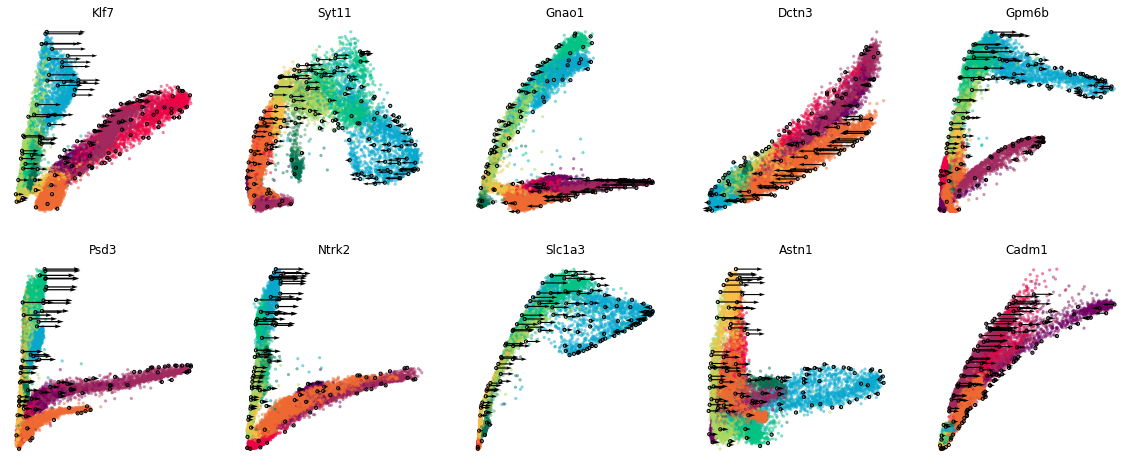

dynamic


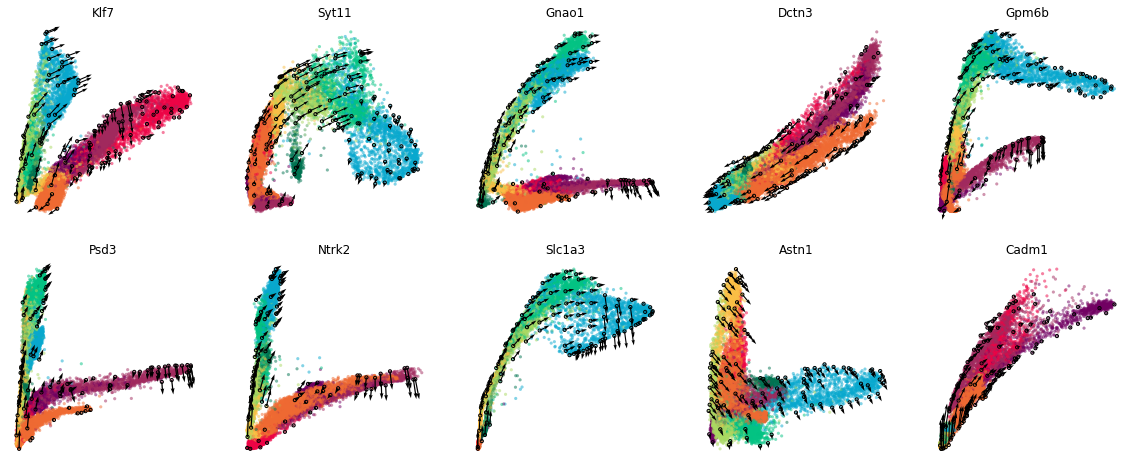

In [39]:
gene_list=['Klf7','Syt11','Gnao1','Dcx','Dctn3',
           'Gpm6b','Ptpro','Psd3','Ntrk2','Ncald',
           'Slc1a3','Astn1','Evl','Tbc1d16','Cadm1']

gene_list=['Klf7','Syt11','Gnao1','Dctn3',
           'Gpm6b','Psd3','Ntrk2',
           'Slc1a3','Astn1','Cadm1']

print('static')
import math
# gene_list=list(splice_unsplice_splice_predict_unsplice_predict_static.gene_name.drop_duplicates())[0:30]

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=splice_unsplice_splice_predict_unsplice_predict_static,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 10,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    ax.axis('off')
plt.savefig('/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/velocity_result/storyboard/gene_velocity_static.pdf')

plt.show()


print('dynamic')
import math
# gene_list=list(splice_unsplice_splice_predict_unsplice_predict_dynamic.gene_name.drop_duplicates())[0:30]

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=splice_unsplice_splice_predict_unsplice_predict_dynamic,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 10,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    ax.axis('off')
plt.savefig('/Users/wanglab/Documents/ShengyuLi/Velocity/data/neuro/scvelo_predict_result/velocity_result/storyboard/gene_velocity_dynamic.pdf')
plt.show()